# Test coordinates with merge

This notebook demonstrates why it is important to use the exact values for grid parameters when defining coordinates.

## Problem: 
In spite of conventions such as CF and COARDS requiring projected coordinates to be specified for multidimensional arrays, some datasets do not contain this information.  Coordinate values have to be generated.  Coordinate values also need to be generated if we are creating a dataset from scratch.  Grid cell height and width, and the x and y projected coordinates for the upper-left corner of the upper-left grid cell are required.  In many cases (but not all), this information is found in Dataset User Guides and in [A Guide to EASE Grids](https://nsidc.org/data/user-resources/help-center/guide-ease-grids#anchor-9) and [A Guide to Polar Stereographic Grids](https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection).  The later page required more work to get the required parameters.

The projected coordinates of a grid cell can be found using the following formulas:

$$
x = (grid\_cell\_width \times row) + x\_upper\_left\_corner
$$
$$
y = (grid\_cell\_height \times column) + y\_upper\_left\_corner)
$$

This equations assumes that the origin of the image coordinates start at row=0. and column=0. in the upper-left corner of the upper-left grid cell.  So the center of the upper-left grid cell is row=0.5 and column=0.5.  Adding 0.5 to row and column indices solves this problem.

These equations can also be expressed using linear alegebra.

$$
\mathbf{Ar} = \\
\begin{pmatrix}
a & 0 & b \\
0 & c & d \\
0 & 0 & 1
\end{pmatrix}
\enspace
\begin{pmatrix}
row \\
col \\
1
\end{pmatrix}
=
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
= \mathbf{x}
$$

where $a$ is `grid_cell_width`, $b$ is `x_upper_left_corner`, $c$ is `grid_cell_height`, and $d$ is `grid_cell_height`.  $\mathbf{A}$ is the augmented Affine Matrix.  We can use the `Affine` class from the `affine` package to define this matrix.

Grid cell width and height for the original EASE Grid(s) and for global EASE Grid 2.0 are defined as a fraction of the Equator so that a whole number of grid cells span the Equator.  This is not strictly necessary for polar azimuthal versions of grids but in the original EASE Grid grid definitions both global and polar grids follow this convention.  For EASE Grid 2.0, polar azimuthal versions of grids use whole kilometers for cell size definitions.  Only the global grid uses a fractional cell size.  A definitive source of grid definitions is the [`mapxmaps`]( https://github.com/nsidc/mapxmaps) repo and the gpd files therein.

Tables in User Guides and in the [A Guide to EASE Grids](https://nsidc.org/data/user-resources/help-center/guide-ease-grids#anchor-9) truncate cell height and widths, and x and y projected coordinates for the upper-left corners of upper left pixels to two decimal places.  Actual values caleculated from gpd files have up to 9 decimal places.  

While a fraction of a millimeter or even a micron may not matter for geolocation, especially for 25 km or even 1 km grids, it does matter for operations for that compare coordinates.  Consider, merging two grids using the `xarray` package.  One grid `data1` has coordinates defined using the high-precision grid parameters.  The other, `data2` has the coordinates defined using grid parameters truncated to two decimal places.  As the workflow below demonstrates, the two coordinates do not form a common set and are concatenated.  

In [20]:
import xarray as xr

from affine import Affine
import numpy as np

In [21]:
grid_cell_width = 36032.220840584
grid_cell_height = -36032.220840584
x_upper_left_corner = -17367530.4451615
y_upper_left_corner = 7314540.8306386

In [22]:
transform1 = Affine(grid_cell_width, 0.0, x_upper_left_corner, 
                   0.0, grid_cell_height, y_upper_left_corner)
transform1

Affine(36032.220840584, 0.0, -17367530.4451615,
       0.0, -36032.220840584, 7314540.8306386)

In [23]:
nrow = 406
ncol = 964
row = np.arange(0.5, nrow)
column = np.arange(0.5, ncol)

x1, _ = transform1 * (column, 0.5)
_, y1 = transform1 * (0.5, row)

data = np.ones((ncol, nrow), 'f')

In [24]:
ds1 = xr.DataArray(data, coords=[x1, y1], dims=['x', 'y'], name='data1')
ds1

<xarray.DataArray 'data1' (x: 964, y: 406)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
Coordinates:
  * x        (x) float64 -1.735e+07 -1.731e+07 ... 1.731e+07 1.735e+07
  * y        (y) float64 7.297e+06 7.26e+06 7.224e+06 ... -7.26e+06 -7.297e+06

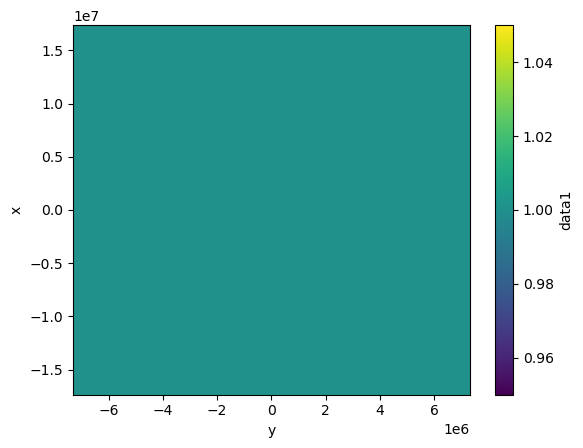

In [34]:
ds1.plot()

In [26]:
transform2 = Affine(round(grid_cell_width, 2), 0.0, round(x_upper_left_corner, 2), 
                   0.0, round(grid_cell_height, 2), round(y_upper_left_corner, 2))
transform2

Affine(36032.22, 0.0, -17367530.45,
       0.0, -36032.22, 7314540.83)

In [27]:
x2, _ = transform2 * (column, 0.5)
_, y2 = transform2 * (0.5, row)

In [28]:
ds2 = xr.DataArray(data, coords=[x2, y2], dims=['x', 'y'], name='data2')
ds2

<xarray.DataArray 'data2' (x: 964, y: 406)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
Coordinates:
  * x        (x) float64 -1.735e+07 -1.731e+07 ... 1.731e+07 1.735e+07
  * y        (y) float64 7.297e+06 7.26e+06 7.224e+06 ... -7.26e+06 -7.297e+06

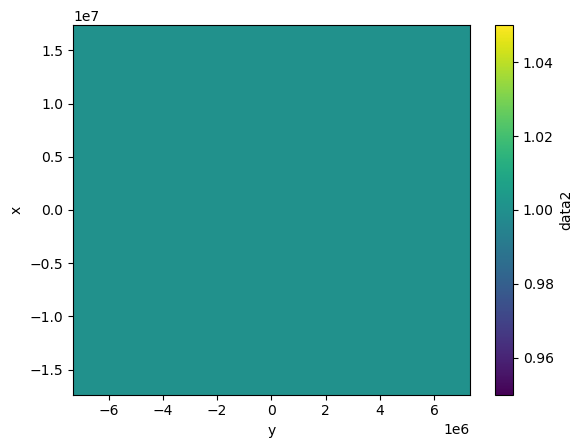

In [35]:
ds2.plot()

In [32]:
ds = xr.merge([ds1, ds2])
ds

<xarray.Dataset>
Dimensions:  (x: 1928, y: 812)
Coordinates:
  * x        (x) float64 -1.735e+07 -1.735e+07 ... 1.735e+07 1.735e+07
  * y        (y) float64 -7.297e+06 -7.297e+06 -7.26e+06 ... 7.297e+06 7.297e+06
Data variables:
    data1    (x, y) float32 nan nan nan nan nan nan ... 1.0 nan 1.0 nan nan 1.0
    data2    (x, y) float32 nan 1.0 nan 1.0 nan 1.0 ... nan nan nan nan nan nan

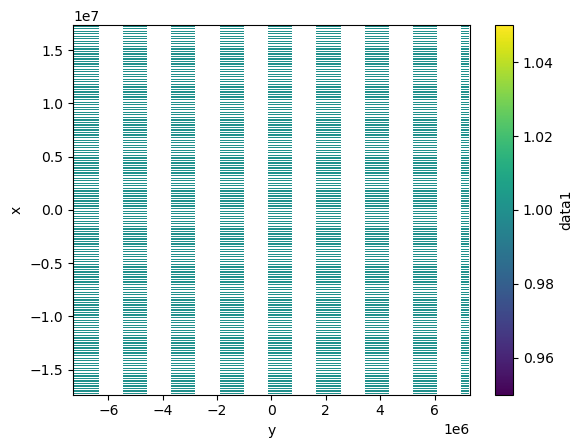

In [33]:
ds.data1.plot()

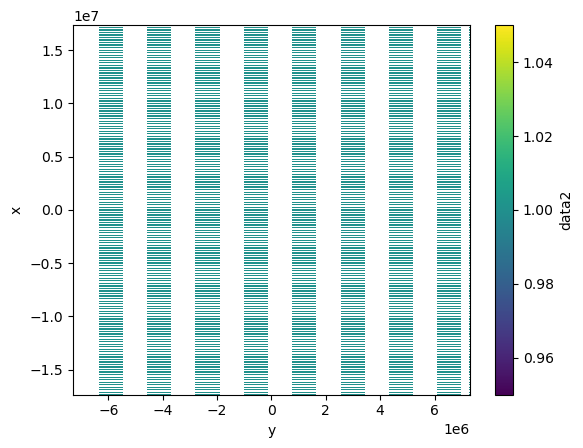

In [36]:
ds.data2.plot()